# Integrated gradients for a ResNet model trained on Imagenet dataset

In this notebook we apply the integrated gradients method to a pretrained ResNet model trained on the Imagenet data set. Integrated gradients defines an attribution value for each feature (in this case for each pixel and channel in the image) by integrating the model's gradients with respect to the input along a straight path from a baseline instance $x^\prime$ to the input instance $x.$

A more detailed description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb). Integrated gradients was originally proposed in Sundararajan et al., ["Axiomatic Attribution for Deep Networks"](https://arxiv.org/abs/1703.01365)

In [1]:
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import matplotlib.pyplot as plt
from alibi.explainers import IntegratedGradients
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from alibi.datasets import fetch_imagenet
from alibi.utils.visualization import visualize_image_attr
print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly())

TF version:  1.15.0
Eager execution enabled:  True


## Load data

Load 3 images from the Imagenet dataset, all belonging to the category "Persian cat". 

In [2]:
category = 'Persian cat'
image_shape = (224, 224, 3)
data, labels = fetch_imagenet(category, nb_images=3, target_size=image_shape[:2], seed=2, return_X_y=True)
print('Images shape: {}'.format(data.shape))
data = (data / 255).astype('float32')

Images shape: (3, 224, 224, 3)


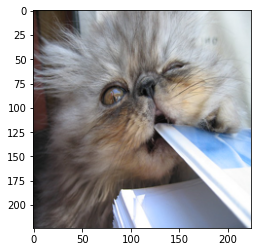

In [31]:
i = 0
plt.imshow(data[i]);

## Load model

Load a pretrained tensorflow model with a ResNet architecture trained on the Imagenet dataset.

In [4]:
model = ResNet50V2(weights='imagenet')

## Calculate integrated gradients

The IntegratedGradients class implements the integrated gradients features attributions method. A description of the method can be found [here](../doc/source/methods/IntegratedGradients.ipynb).

In the first example, the baselines (i.e. the starting points of the path integral) are black images (all pixel values are set to zero). This means that black areas of the image will always have zero attributions. In the second example we consider random uniform noise baselines. 
The path integral is defined as a straight line from the baseline to the input image. The path is approximated by choosing 50 discrete steps according to the Gauss-Legendre method.

In [5]:
n_steps = 500
method = "average_uniform"
internal_batch_size = 50
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method,
                          internal_batch_size=internal_batch_size)

In [22]:
predictions = model(data).numpy().argmax(axis=1)
explanation = ig.explain(data,
                         sigma=0.5,
                         baselines='average_gaussian', 
                         target=predictions)

800A
['riemann_left', 'riemann_right', 'riemann_middle', 'riemann_trapezoid', 'gausslegendre']
Convergence delta not computable


In [23]:
# Metadata from the explanation object
explanation.meta

{'name': 'IntegratedGradients',
 'type': ['whitebox'],
 'explanations': ['local'],
 'params': {'method': 'average_uniform',
  'n_steps': 500,
  'internal_batch_size': 50,
  'layer': 0}}

In [24]:
# Data fields from the explanation object
explanation.data.keys()

dict_keys(['attributions', 'X', 'baselines', 'predictions', 'deltas', 'target'])

In [25]:
# Get attributions values from the explanation object
attrs = explanation.attributions

## Visualize attributions

### Black image baseline

Sample image from the test set and its attributions. The attributions are shown by overlaying the attributions values for each pixel to the original image. The attribution value for a pixel is obtained by summing up the attributions values for the three color channels. The attributions are scaled in a $[-1, 1]$ range: red pixels represent negative attributions, while green pixels represent
positive attributions. The original image is shown in gray scale for clarity. 

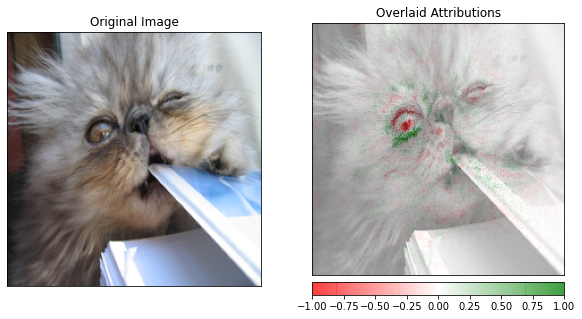

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
visualize_image_attr(attr=None, original_image=data[i], method='original_image',
                    title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False);

visualize_image_attr(attr=attrs[i], original_image=data[i], method='blended_heat_map',
                    sign='all', show_colorbar=True, title='Overlaid Attributions',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True);

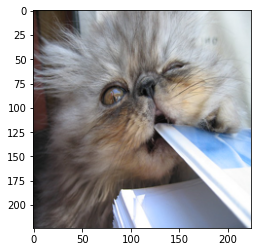

In [33]:
plt.imshow(data[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


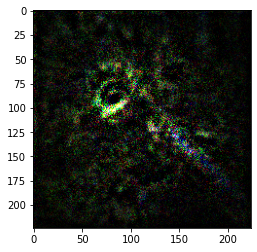

In [34]:
plt.imshow(5 * (attrs[i] / attrs[i].max()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


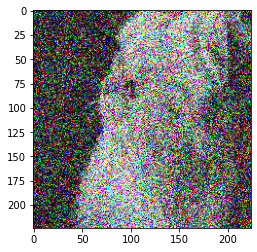

In [35]:
plt.imshow(explanation.baselines[10, 2])

In [30]:
np.allclose(explanation.baselines[10, 2], explanation.baselines[1, 2])

False

### Random baselines

Here we show the attributions obtained choosing random uniform noise as a baseline. It can be noticed that the attributions can be considerably different from the previous example, where the black image is taken as a baseline. An extensive discussion about the impact of the baselines on integrated gradients attributions can be found  in P. Sturmfels at al., ["Visualizing the Impact of Feature Attribution Baselines"](https://distill.pub/2020/attribution-baselines/).

In [12]:
baselines = np.random.random_sample(data.shape)

In [13]:
explanation = ig.explain(data, 
                         baselines=baselines, 
                         target=predictions)

In [14]:
attrs = explanation.attributions

Sample image from the test dataset and its attributions. The attributions are shown by overlaying the attributions values for each pixel to the original image. The attribution value for a pixel is obtained by summing up the attributions values for the three color channels. The attributions are scaled in a $[-1, 1]$ range: red pixel represents negative attributions, while green pixels represents positive attributions. The original image is shown in gray scale for clarity. 

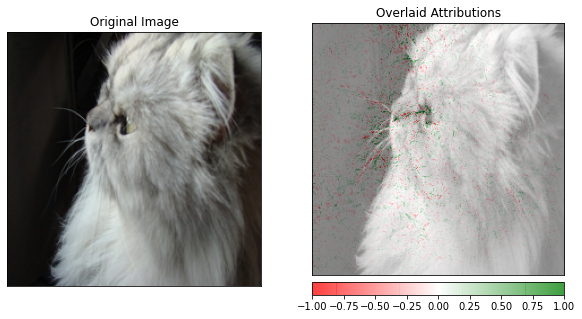

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
visualize_image_attr(attr=None, original_image=data[i], method='original_image',
                    title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False);

visualize_image_attr(attr=attrs[i], original_image=data[i], method='blended_heat_map',
                    sign='all', show_colorbar=True, title='Overlaid Attributions',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True);